## Рекомендательная система
Задача:  
1 по данным оценкам товаров предсказать, какую оценку поставит пользователь новому для него товару  
2 дать рекомендации товаров пользователю  
Каггл: https://www.kaggle.com/c/recommendationsv4/

In [1]:
# импорт библиотек для анализа данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse

%matplotlib inline


# импорт библиотек для построения модели
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split


C:\apps\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
# читаем файлы
data_train = pd.read_csv('data/train.csv')   # данные для обучения
data_test = pd.read_csv('data/test.csv')  # данные для предсказаний на Каггл
submission = pd.read_csv('data/sample_submission.csv')  # шаблон для сабмита на каггл

# Сохраним первоначальные файлы, будем работать с копиями
train = data_train.copy() 
test = data_test.copy()  

C:\apps\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\apps\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1 Анализ датасета EDA

### 1.1 Датасет train - информация по парам itemid-userid

In [3]:
# посмотрим, что вообще представляет из себя датасет: это сведения об отзывах, которые сделали пользователи по товарам
print('train.shape = ', train.shape)
train.head(5)

train.shape =  (857895, 14)


,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


In [4]:
# посмотрим на типы данных и количество пропущенных значений
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


Есть немного пропусков в поле *reviewerName*. Cкорее всего, это никак не должно влиять на остальные данные. Посмотрим, как выглядят данные с пропущенными *reviewerName*. Видим, что в остальном данные выглядят ок, поэтому просто удалим этот столбец и будем идентифицировать пользователья только по *userid*. Дополнительно убедимся в этом, посмотрев на распределениe первоначальной оценки *overall* и разброс времени оставления отзывов для клиентов с наличием *reviewerName* и его отсутствием.

In [5]:
train[train.reviewerName.isna()].sample(3)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
715307,5.0,False,"12 15, 2015",B015GZWXX0,NaN,These are quite fancy pieces of Baklava! My h...,"I myself found the taste a bit too sweet, but ...",1450137600,NaN,NaN,['https://images-na.ssl-images-amazon.com/imag...,125499,35393,1.0
24606,5.0,True,"10 9, 2015",B0029J6HU2,NaN,Nice,Love,1444348800,NaN,NaN,NaN,20032,10382,1.0
762137,5.0,False,"04 19, 2015",B00U9XF4EU,NaN,The taste is wonderful. Nice green color.\nThe...,"Delicious, Fresh Matcha.",1429401600,2,NaN,NaN,48843,32929,1.0


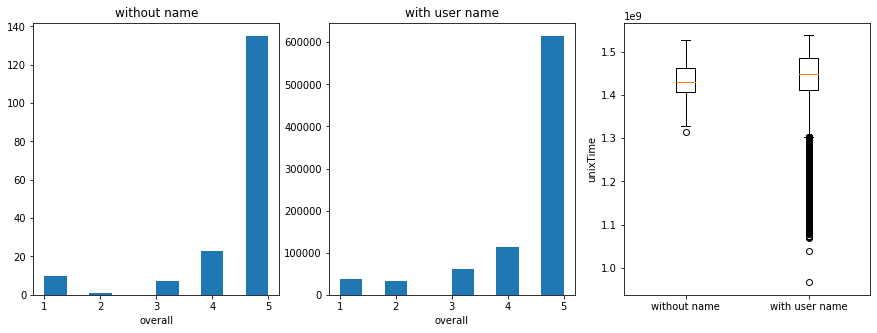

In [6]:
fig, axes = plt.subplots(1, 3, figsize = (15,5))
axes[0].set_title('without name')
axes[0].set_xlabel('overall')
axes[1].set_xlabel('overall')
axes[1].set_title('with user name')
axes[0].hist(train[train.reviewerName.isna() == True].overall)
axes[1].hist(train[train.reviewerName.isna() == False].overall)
axes[2].set_ylabel('unixTime')
axes[2].boxplot([train[train.reviewerName.isna()].unixReviewTime, train[train.reviewerName.isna() == False].unixReviewTime],
               labels=['without name', 'with user name'])
plt.show()

Также есть пропуски в столбцах:  
*vote* - количество проголосовавших за отзыв, заполние его нулями  
*style* - какие-то характеристики товара, 
*image* - пропусков очень много, к тому же это просто ссылка на картинку --> удалим

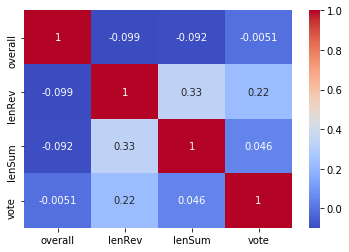

In [7]:
# стобец asin - будет нужен для формирования таблицы item_features

# определим длину отзыва в символах и посмотрим, влияет ли на оценку
train['lenRev'] = train['reviewText'].apply(lambda x: len(str(x)))
train['lenSum'] = train['summary'].apply(lambda x: len(str(x)))
train['vote'] = train.vote.apply(lambda x: str(x).replace(',',''))
train['vote'] = train['vote'].fillna('0').astype('float64')
sns.heatmap(train[['overall', 'lenRev', 'lenSum', 'vote']].corr(), cmap='coolwarm', annot=True)
# связи практически нет с целевой переменной, эти столбцы не нужны
#   также нет связи между оценкой и количеством голосований за отзыв - очень слабая

In [8]:
train['vote'] = train['vote'].fillna('0').astype('float64')
train['vote'].isna().sum()

0

### 1.2 Датасет items - создание датасета с информацией по продуктам

In [9]:
#  работа с большим файлом meta_Grocery_and_Gourmet_Food.json
#  Воспользуемся данными по товарам, чтобы сформировать матрицу признаков товаров (item_features)
import json

In [10]:
meta = []
with open('data/meta_Grocery_and_Gourmet_Food.json', 'r') as in_file:
    for line in in_file:
        meta.append(json.loads(line))

Что представляет собой этот метафайл:
список словарей, описывающих продукты. Длина словарей разная:
{4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}  
Ключи такие: {'also_buy',
 'also_view',
 'asin',
 'brand',
 'category',
 'date',
 'description',
 'details',
 'feature',
 'fit',
 'image',
 'main_cat',
 'price',
 'rank',
 'similar_item',
 'tech1',
 'title'}
 Сделаем из этого метафайла датафрейм с признаками товаров. Потом в модель добавим разреженную матрицу, с указанием category каждого продукта. Возьмем следующие признаки: 'asin', ''brand', 'category', 'main_cat', description, price, 
 В категории последних элементов - 1175 штук;
 предпоследних - 234;
 первых - 1; вторых - 26.
 main_cat - 27 штук (совпадает со второй позицией в категории)
 brands - 38915 штук. 

In [14]:
#посмотрим, что представляет из себя файл json
type(meta), len(meta), type(meta[0])

(list, 287209, dict)

In [15]:
#Создадим фичи для продуктов
items = train[['itemid', 'unixReviewTime']].groupby('itemid').count() # сосчитаем, сколько всего отзывов на товар было оставлено
items['asin'] = train[['itemid', 'asin']].groupby('itemid').first()

In [16]:
items.columns = ['NoRev', 'asin']
items['item_id'] = items.index
items.sample(5)

,NoRev,asin,item_id
itemid,,,
27925,13,B00IZ8LQO8,27925
1741,7,B000ESWFHE,1741
9948,27,B001YJ6M7Q,9948
29018,9,B00KM562EG,29018
16209,7,B005KRYEZU,16209


In [20]:
# добавим среднюю оценку для каждого товара
items['overall_av'] = train[['itemid', 'overall']].groupby('itemid').mean()

In [19]:
items

,NoRev,asin,item_id,OverAll_Av
itemid,,,,
0,8,4639725183,0,4.875000
1,21,4639725043,1,4.190476
2,7,5463213682,2,4.857143
3,74,9742356831,3,4.581081
4,10,B00004S1C5,4,4.400000
...,...,...,...,...
41315,4,B01H8ET97A,41315,4.000000
41316,3,B01H8ET9G6,41316,4.666667
41317,4,B01H8FA2U2,41317,4.250000


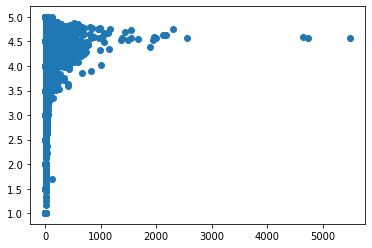

In [21]:
# Посмотрим на зависимость средней оценки от количетсва отзывов
plt.scatter(items.NoRev, items.overall_av)
# видим, что для часто покупаемых товаров характерны высокие оценки

In [22]:
# запишем для каждого товара наименование бренда
def set_brand(asin):
    for elem in meta:
        if elem.get('asin') == asin:
            return elem.get('brand')
    return('None')

items['brand'] = items['asin'].apply(set_brand)

In [23]:
# запишем категорию  (самую последнюю )
def set_category(asin):
    for elem in meta:
        if elem.get('asin') == asin:
            return elem.get('category')[-1]
    return('None')

items['category'] = items['asin'].apply(set_category)

In [24]:
def set_title(asin):
    for elem in meta:
        if elem.get('asin') == asin:
            return elem.get('title')
    return('None')

items['title'] = items['asin'].apply(set_title)

In [25]:
def set_main_cat(asin):
    for elem in meta:
        if elem.get('asin') == asin:
            return elem.get('main_cat')
    return('None')

items['main_cat'] = items['asin'].apply(set_main_cat)

In [26]:
def set_price(asin):
    for elem in meta:
        if elem.get('asin') == asin:
            return elem.get('price')
    return('None')

items['price'] = items['asin'].apply(set_price)

In [27]:
#даю каждой категории свой id
set_category = set(items.category.unique())
print(f'всего категорий: {len(set_category)}')
mapper = dict(zip(set_category, range(len(set_category))))
items['cat_id'] = items['category'].apply(lambda x: mapper[x])

всего категорий: 967


In [28]:
# запишем получившийся датафрейм в файл
items.to_csv('data/items.csv')

### для повторных экспериментов прочитаем *items* из файла

In [9]:
items = pd.read_csv('data/items.csv')

In [10]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41302 entries, 0 to 41301
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   itemid      41302 non-null  int64  
 1   NoRev       41302 non-null  int64  
 2   asin        41302 non-null  object 
 3   item_id     41302 non-null  int64  
 4   OverAll_Av  41302 non-null  float64
 5   overall_av  41302 non-null  float64
 6   brand       40877 non-null  object 
 7   category    41302 non-null  object 
 8   title       41302 non-null  object 
 9   main_cat    41219 non-null  object 
 10  price       25281 non-null  object 
 11  cat_id      41302 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 3.8+ MB


In [11]:
# посмотрим на пропущенные бренды - в остальном данный обычные
items[items.brand.isna()].sample(5)

,itemid,NoRev,asin,item_id,OverAll_Av,overall_av,brand,category,title,main_cat,price,cat_id
38329,38342,2,B0001CWG9A,38342,2.500000,2.500000,NaN,Pancakes & Waffles,Buckwheat Pancake and Waffle Mix,Grocery,NaN,74
20321,20327,5,B009ZIK1MK,20327,4.400000,4.400000,NaN,Macadamia Nuts,"Raw Macadamia Nuts, 1 lb",Grocery,NaN,101
32758,32766,6,B00TXMKZBA,32766,4.000000,4.000000,NaN,Roasted Coffee Beans,Dancing Moon Ethiopian Yirgacheffe Whole Bean ...,Grocery,NaN,80
25070,25077,5,B00EZWT7MG,25077,4.000000,4.000000,NaN,Potato,Pringles Sour Cream & Onion Fat Free Potato Cr...,Grocery,NaN,726
28294,28301,17,B00JJQLNDO,28301,4.117647,4.117647,NaN,Single-Serve Capsules & Pods,100 Foil Seals to Reuse Your Keurig Rivo Packs...,Grocery,NaN,247


In [12]:
# посмотрим на пропущенные main_cat - в целом обычные
items[items.main_cat.isna()].sample(5)

,itemid,NoRev,asin,item_id,OverAll_Av,overall_av,brand,category,title,main_cat,price,cat_id
32305,32313,5,B00SDWGAAQ,32313,4.40,4.40,JM BAMBOO,House Plants,Terrarium & Fairy Garden Plants - 10 Plants in...,NaN,$28.99,216
9706,9712,3,B001TK9YAM,9712,5.00,5.00,Little Debbie,Candy & Chocolate Bars,"Little Debbie Snacks Nutty Bars, 12-Count Box",NaN,$14.97,308
10708,10714,10,B002E4AFJQ,10714,4.70,4.70,Candy Crate,Candy & Chocolate,Key Lime Disks - 5lb,NaN,$18.16,70
32138,32146,4,B00RNRQU48,32146,3.75,3.75,JM BAMBOO,Live Indoor Plants,"jmbamboo-Goldfish Plant - 4"" Hanging Basket - ...",NaN,$14.99,27
5068,5070,5,B000WIFW9O,5070,1.80,1.80,Butlers,Candy & Chocolate Bars,Butler's Irish Chocolate - Irish Coffee,NaN,NaN,308


## 2 Обработка данных

### 2.1 Строим матрицу взаимодействий, строки: userid; столбцы: itemid

In [13]:
# удалим колонку reviewerName из тренировочного датасета
train.drop('reviewerName', axis = 1, inplace = True)

# переведем дату в формат datetime. 
# Дублирующий столбец unixReviwTime удалать не будем
train.reviewTime = pd.to_datetime(train.reviewTime)

# удалим дублирующиеся отзывы, так как при построении разреженной матрицы значения рейтингов складываются. 
# Это не отражает реальную ситуацию
train.drop_duplicates(subset=['userid', 'itemid'], keep='last', inplace=True)

# удалим столбцы style и image
train.drop(['style', 'image'], axis=1, inplace=True)

train

,overall,verified,reviewTime,asin,reviewText,summary,unixReviewTime,vote,userid,itemid,rating,lenRev,lenSum
0,5.0,True,2016-10-04,B01CPNIEQG,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,0.0,102179,37138,1.0,231,31
1,5.0,True,2016-03-01,B006F63M8U,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,0.0,3625,17322,1.0,81,39
2,5.0,True,2016-06-26,B00112O8NG,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28.0,39495,5600,1.0,1541,56
3,5.0,True,2013-09-05,B00MRAQUM8,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,0.0,72854,30249,1.0,252,6
4,5.0,True,2016-09-14,B000R7RN0G,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,0.0,74859,4349,1.0,119,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
857890,5.0,True,2013-04-02,B000H7ELTW,Next to the round variety hanging on my cherry...,next to the round variety............,1364860800,0.0,59433,2566,1.0,284,37
857891,2.0,True,2015-12-13,B0012NI02O,Not my cup of tea.,Two Stars,1449964800,0.0,86473,5828,0.0,18,9
857892,4.0,False,2016-09-21,B000LKX6R8,"I really like these noodles, I just gave it on...",good but better value elsewhere,1474416000,0.0,88,3251,1.0,183,31
857893,4.0,True,2015-11-01,B00BUKL666,"I like these, they are the kind for a snack an...",Great selection,1446336000,0.0,41540,22208,1.0,182,15


In [14]:
# построим разреженную матрицу взаимодействий
ratings_coo = sparse.coo_matrix((train['rating'].astype(int),
                                 (train['userid'],train['itemid'])))

train_rating_coo, test_rating_coo = random_train_test_split(ratings_coo)

### 2.2 Строим разреженную матрицу признаков по товарам

Для этого используем следующие данные:  
1 Категорию продукта (последнее значение в категориях продукта из файла meta  
2 Общее количество отзывов на каждый продукт  
3 Средняя оценка по 5-ти балльной шкале  

In [15]:
# Приведем NoRev к шкале от 0 до 5, чтобы сделать соразмерным оценке Overall
items['NoRev'] = 5 * items['NoRev']/items['NoRev'].max()

In [16]:
# Обработка признаков товаров
def item_feats_to_sparse(df_items):
    N_items=df_items.itemid.max() + 1
    N_cat = df_items.cat_id.max() + 1
    
    # данные, которые будут храниться в разреженной матрице:
    # 1-категори (передаем единицы, которые будут соответствовать столбцу с номером категории)
    # 2 - NoRev - количеcтво отзывов на товар
    # 3 - OverAll -средняя оценка по 5-ти балльной шкале
    
    data = np.concatenate([np.array([1] * len(df_items)), 
                           df_items.NoRev.values,
                           df_items.OverAll_Av.values])
    
    # номера строк - повторим трижды список itemid
    rows_ids = np.tile(df_items.itemid, 3)
    
    # номера колонок
    # 1-номер категории
    # 2 - одна колонка, номер = макс. категорией + 1
    # 3 - одна колонка, номер = макс. категорией + 2
    col1 = df_items.cat_id.values
    col2 = np.array([N_cat + 1] * len(df_items))
    col3 = np.array([N_cat + 2] * len(df_items))
    cols_ids = np.concatenate((col1, col2, col3))
    
    return sparse.coo_matrix((data, (rows_ids,cols_ids)))
    
item_features = item_feats_to_sparse(items)

In [17]:
item_features

<41320x970 sparse matrix of type '<class 'numpy.float64'>'
	with 123906 stored elements in COOrdinate format>

# 3 Создание модели

## 3.1 Построим пробную модель из baseline

In [30]:
NUM_THREADS = 2 #число потоков
NUM_COMPONENTS = 20 #число параметров вектора 
NUM_EPOCHS = 10 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(train_rating_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [31]:
#  Сделаем предсказание на тестовой выборке
preds = model.predict(test_rating_coo.row,
                      test_rating_coo.col)


In [32]:
# Посмотрим на метрику из LighfFM:
auc_LFM = auc_score(model=model, test_interactions=test_rating_coo)
auc_LFM.max(), auc_LFM.min(), auc_LFM.mean()

(1.0, 0.0, 0.7169594)

In [33]:
# сравним с метрикой из склерна
sklearn.metrics.roc_auc_score(test_rating_coo.data,preds)
# Вывод: отличается, но не очень сильно.

0.7266298373772178

In [28]:
# Посчитаем precision, recall.
pr_at_k = precision_at_k(model=model, test_interactions=test_rating_coo, k=5)
rc_at_k = recall_at_k(model=model, test_interactions=test_rating_coo, k=5)
print(f'Precision: {pr_at_k.mean()}, recall: {rc_at_k.mean()}')

Precision: 0.012802104465663433, recall: 0.03851881797204211


In [34]:
# Сделаем предсказание на каггл
# Для этого обучим модель на всех имеющихся данных
model_kaggle = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model_kaggle = model_kaggle.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)
preds_kaggle = model_kaggle.predict(test.userid.values,
                                 test.itemid.values)
preds_kaggle = (preds_kaggle - preds_kaggle.min())/(preds_kaggle.max() - preds_kaggle.min())
submission['rating'] = preds_kaggle
submission.to_csv('data/submission_base.csv', index=False)

## Промежуточный итог
Базовая модель работает, найдены метрики для нее, можно делать предсказания.  
RocAuc для тестовых данных: 0.716 (LightFM), 0.727 (sklern)  
для Каггл:  0.76156  
Метрики вычисленные: RocAuc, Precision, Recall.
Можно также получить эмбединги и биасы.
следующий этап -  Кросс валидация, подбор параметров модели

## 3.2 Подбор параметров модели и добавление признаков

In [21]:

# параметры, по которым потом тоже сделаем решетку
LOSS_TYPE_LIST =['logistic','warp']
LR_LIST = [0.05, 0.1]

# создадим датафрейм, куда будем записывать 
No_params = 0  #счетчик для набора параметров
results = pd.DataFrame(columns = ['NoComp', 'NoEpoch', 'LossType', 'LearnineRate', 'No_params',
                                 'No_cv', 'sk_RocAuc', 'LFM_RocAuc', 'pr_at_k', 'rc_at_k' ])

def LFM_result(train_gr_coo, test_gr_coo):
    
    model_gr = LightFM(learning_rate=LR, loss=LOSS_TYPE,
                                no_components=NUM_COMPONENTS)
    model_gr = model_gr.fit(train_gr_coo, epochs=NUM_EPOCHS, 
                                  num_threads=NUM_THREADS)
    
    # метрика по LightFM
    LFM_RocAuc = auc_score(model=model_gr, test_interactions=test_gr_coo).mean()
    
    # проверка по склерну
    test_gr_df = pd.DataFrame(data=np.array([test_gr_coo.row, test_gr_coo.col, test_gr_coo.data]).transpose(),
                      columns=['userid', 'itemid', 'rating'])
    preds = model_gr.predict(test_gr_df.userid.values, 
                                 test_gr_df.itemid.values)
    sk_RocAuc = sklearn.metrics.roc_auc_score(test_gr_df.rating.values,preds)
    
    # presicion, recall
    pr_at_k = 0
    rc_at_k = 0
    # pr_at_k = precision_at_k(model=model_gr, test_interactions=test_rating_coo, k=5).mean()
    # rc_at_k = recall_at_k(model=model_gr, test_interactions=test_rating_coo, k=5).mean()
    
    return sk_RocAuc, LFM_RocAuc, pr_at_k, rc_at_k


In [ ]:
NUM_THREADS = 4 #число потоков
for NUM_COMPONENTS in  np.arange(35, 55, 5):
    for NUM_EPOCHS in np.arange(10, 40, 10):
        print(f'no_components: {NUM_COMPONENTS}, epochs: {NUM_EPOCHS}')
        for LOSS_TYPE in LOSS_TYPE_LIST:
            for LR in LR_LIST:
                No_params += 1
                for i in range(5):
                    No_cv = i
                    train_gr_coo, test_gr_coo = random_train_test_split(ratings_coo)
                    sk_RocAuc, LFM_RocAuc, pr_at_k, rc_at_k = LFM_result(train_gr_coo, test_gr_coo)
                    results = results.append(pd.DataFrame([[NUM_COMPONENTS, NUM_EPOCHS,
                                                           LOSS_TYPE, LR, No_params, No_cv,
                                                           sk_RocAuc, LFM_RocAuc, pr_at_k, rc_at_k 
                                                           ]],
                                                         columns=['NoComp', 'NoEpoch', 'LossType', 'LearnineRate', 'No_params',
                                                             'No_cv', 'sk_RocAuc', 'LFM_RocAuc', 'pr_at_k', 'rc_at_k' ]))
                    results.to_csv('data/results.csv')


no_components: 35, epochs: 10
no_components: 35, epochs: 20
no_components: 35, epochs: 30
no_components: 40, epochs: 10
no_components: 40, epochs: 20


In [26]:
# датафрейм для параметров
# параметры: NumComponent, NumEpoch, Loss, learning_rate

In [35]:
results_cv = pd.read_csv('data/results.csv')
results_cv.groupby(['NoComp', 'NoEpoch', 'LossType', 'LearnineRate']).mean()

Unnamed: 0  No_params  No_cv  sk_RocAuc  \
NoComp NoEpoch LossType LearnineRate                                            
35     10      logistic 0.05                   0          1      2   0.693214   
                        0.10                   0          2      2   0.725530   
               warp     0.05                   0          3      2   0.541729   
                        0.10                   0          4      2   0.522651   
       20      logistic 0.05                   0          5      2   0.719560   
                        0.10                   0          6      2   0.723176   
               warp     0.05                   0          7      2   0.539154   
                        0.10                   0          8      2   0.520996   
       30      logistic 0.05                   0          9      2   0.721815   
                        0.10                   0         10      2   0.712778   
               warp     0.05                   0         11      2   0.537487   
                        0.10                   0         12      2   0.517427   
40     10      logistic 0.05                   0         13      2   0.692227   
                        0.10                   0         14      2   0.726797   
               warp     0.05                   0         15      2   0.542725   
                        0.10                   0         16      2   0.522997   
       20      logistic 0.05                   0         17      2   0.718759   
                        0.10                   0         18      2   0.724587   
               warp     0.05                   0         19      2   0.538560   
                        0.10                   0         20      2   0.521117   
       30      logistic 0.05                   0         21      2   0.723231   
                        0.10                   0         22      2   0.714231   
               warp     0.05                   0         23      2   0.538638   
                        0.10                   0         24      2   0.521862   
45     10      logistic 0.05                   0         25      2   0.693397   
                        0.10                   0         26      2   0.726712   
               warp     0.05                   0         27      2   0.542346   
                        0.10                   0         28      2   0.524339   
       20      logistic 0.05                   0         29      2   0.720750   
                        0.10                   0         30      2   0.724236   
               warp     0.05                   0         31      2   0.541756   
                        0.10                   0         32      2   0.524466   
       30      logistic 0.05                   0         33      2   0.723239   
                        0.10                   0         34      2   0.713567   
               warp     0.05                   0         35      2   0.539683   
                        0.10                   0         36      2   0.521640   
50     10      logistic 0.05                   0         37      2   0.691954   
                        0.10                   0         38      2   0.725226   
               warp     0.05                   0         39      2   0.543248   
                        0.10                   0         40      2   0.524302   
       20      logistic 0.05                   0         41      2   0.719281   
                        0.10                   0         42      2   0.726264   
               warp     0.05                   0         43      2   0.542097   
                        0.10                   0         44      2   0.524113   
       30      logistic 0.05                   0         45      2   0.723106   
                        0.10                   0         46      2   0.717257   
               warp     0.05                   0         47      2   0.540697   
                        0.10                   0         48      2   

#### Получили, что наилучшие результаты будут с параметрами:
NUM_COMPONENTS = 35  
NUM_EPOCHS = 10  
LOSS_TYPE = 'logistic'

Добавим теперь к этой модели признаки товаров и регуляризацию.
По результатам аналогичных экспериментов получили, что лучшими параметрами будут:



In [18]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 35
NUM_EPOCHS = 10
LR = 0.1
alphas = 0.00001
LOSS_TYPE = 'logistic'


In [22]:
#Создаём модель с регуляриацией и использованием признаков товаров
model_reg = LightFM(learning_rate=LR, loss=LOSS_TYPE, no_components=NUM_COMPONENTS)
                   #item_alpha=alphas, user_alpha=alphas)

#Обучаем модель
model_reg = model_reg.fit(train_rating_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS,
                  item_features=item_features)

# сделаем предсказание для тестовой выборки
preds = model_reg.predict(test_rating_coo.row,
                     test_rating_coo.col,
                     item_features=item_features)

# RocAuc из sklern:
sklearn.metrics.roc_auc_score(test_rating_coo.data, preds)

0.7255229361510378

#### Обучаем модель на полной выборке и делаем предсказание на Каггл

In [24]:
#Создаём модель с регуляриацией для Каггла (полная)
model_reg_kaggle = LightFM(learning_rate=LR, loss=LOSS_TYPE, no_components=NUM_COMPONENTS,
                   item_alpha=alphas, user_alpha=alphas)

#Обучаем модель
model_reg_kaggle = model_reg_kaggle.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS,
                  item_features=item_features)

preds_kaggle = model_reg_kaggle.predict(test.userid.values,
                     test.itemid.values,
                  item_features=item_features)

preds_kaggle = (preds_kaggle - preds_kaggle.min())/(preds_kaggle.max() - preds_kaggle.min())
submission['rating'] = preds_kaggle
submission.to_csv('data/submission_tuned.csv', index=False)

# 4 Рекомендации для пользователя  
Для существующх пользователей дадим рекомендации на основании его покупок, а номым пользователям предложим наиболее популярные товары


In [25]:
# для прототипа создадим сокращенную версию тренировочного набора:
train_reduced = train[['userid', 'itemid', 'overall', 'reviewTime']]
train_reduced.to_csv('data/train_reduced.csv')

N_last = 5 #столько последних покупок будем показывать и к ним давать рекомендации
# Определим номер пользователя, для которого будем давать рекомендации
user_id_for_recommend = 2024 

In [26]:
# получим эмбеддинги и запишем их в файл
item_biases, item_embeddings = model_reg_kaggle.get_item_representations(features=item_features)
user_biases, user_embeddings = model_reg_kaggle.get_user_representations()
user_embeddings.max(), item_embeddings.max()

(0.41164687, 13.032198)

In [27]:
item_features

<41320x970 sparse matrix of type '<class 'numpy.float64'>'
	with 123906 stored elements in COOrdinate format>

In [28]:
import nmslib
 
#Создаём граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
#Добавляем товары в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)



In [29]:
#Вспомогательная функция для поиска по графу
def nearest_item_nms(item_id, index, n=5):
    nn = index.knnQuery(item_embeddings[item_id], k=n)
    return nn

In [50]:
items_recommend_ids = set()
if user_id_for_recommend in train_reduced['userid'].unique():
    
    #выводим весь список покупок для этого пользователя
    train_reduced[train_reduced['userid'] == user_id_for_recommend]
    #список трех последних покупок, оцененных на макс оценку
    last_best_items = train_reduced[train_reduced['userid'] == user_id_for_recommend
                               ].sort_values(by = ['overall', 'reviewTime'], 
                               ascending=False)['itemid'].values[:N_last]
    print(f'Last best items are:')
    for item_id in last_best_items:
        print (items[items['item_id'] == item_id].title)

    # составляем список рекомендаций к последним покупкам
    for item in last_best_items:
        items_recommend_ids.update(nearest_item_nms(item,nms_idx)[0])
else:
    # новым пользователям предложим случайные 10 товаров из числа тех, которые получили оценки 4 и 5 
    # и количество отзывов на них в верхних 20%
    
    print("It's a new user!")
    most_popular_items = items[(items['NoRev'] >= items['NoRev'].quantile(0.95))]
    items_recommend_ids.update(most_popular_items.sample(10)['itemid'].values)
 
print()
print('Recommended items:')
print(items_recommend_ids)
for item_id in items_recommend_ids:
    print (items[items.index == item_id].title)


Last best items are:
37308    Japanese candy assortment 30pcs , full of daga...
Name: title, dtype: object
10374    SNICKERS Almond Sharing Size Chocolate Candy B...
Name: title, dtype: object
3721    Breath Savers Cinnamon Mint Candy, Sugar Free ...
Name: title, dtype: object
19235    Country Spoon Montmorency Red Tart Cherry Juic...
Name: title, dtype: object
3453    Ocean Spray Light Cranberry Juice Drink, 10 Ou...
Name: title, dtype: object

Recommended items:
{6265, 5187, 6500, 6564, 29382, 3723, 23183, 2513, 33885, 39031, 37336, 35193, 38875, 32861, 2398}
6265    Frooties Grape, 360 Piece Bag
Name: title, dtype: object
5187    Create A Treat Create-a-Treat Gingerbread Ging...
Name: title, dtype: object
6500    Japanese Snack Variety Gift Boxset
Name: title, dtype: object
6564    David Seeds Original Sunflower Seeds, 1.75-oun...
Name: title, dtype: object
29382    Judee's Expandex Modified Tapioca Starch (40 o...
Name: title, dtype: object
3723    Gummy Burgers - Mini Gummi Burger

In [51]:
# сохраним эмбеддинги для прототипа
import pickle
with open('data/items_embeddings.pkl', 'wb') as f_out:
    pickle.dump(item_embeddings, f_out)

# 5 Выводы  
1 Построена базовая модель  
2 Подобраны параметры модели с целью уменьшить RocAuc, добавлена регуляризация и признаки товаров: скор незначительно улучшился с  0.727 до 0.732 на моей тестовой выборке. При этом скор на Каггле стал хуже (с 0.76 до 0.75).  
3 Добавлены признаки товаров. Но результат странный: добавление признаков в модель приводит к ухудшению  RocAuc (для 45 комп, 20 эпох - с 0.72 до 0.69 ухудшается при добавлении фич)  
4 Даны рекомендации пользователю на основе эмбеддингов понравившихся товаров  
5 Построен прототип для поиска похожих товаров (на 28.07.2020 работает только по ID товара. Поиск рекомендаций по ID пользователя, по аналогии с данным ноутбуком, - пока не реализован) https://vast-peak-94098.herokuapp.com/ 